# Exploratory geographical data using SparkR and ggplot2

[**Introduction to Apache Spark with R by J. A. Dianes**](https://github.com/jadianes/spark-r-notebooks)

The present analysis will exploit the power of SparkR to analyse large datasets in order to explore the [2013 American Community Survey](http://www.census.gov/programs-surveys/acs/data/summary-file.html) dataset, more concretely its geographical features. For that purpose we will aggregate data using the different tools introduced in the [SparkR documentation](http://spark.apache.org/docs/latest/sparkr.html) and our [series of notebooks](https://github.com/jadianes/spark-r-notebooks), and then use [ggplot2](http://ggplot2.org) mapping capabilities to put the different aggregations into a geographical context.

But why using SparkR? Well, *ggplot* is not intended to be used with datasets of millions of points. We first need to process and aggregate data in order to make it usable. And there is where SparkR comes in handy. Using regular R (e.g. [dplyr](https://cran.rstudio.com/web/packages/dplyr/vignettes/introduction.html)) for doing data aggregations on really large datasets may not scale well. By opening the door to parallel and sitributed data processing using R on Spark, we really start to solve our scalability problems.

## Creating a SparkSQL context and loading data

In order to explore our data, we first need to load it into a SparkSQL data frame. But first we need to init a SparkSQL context. The first thing we need to do is to set up some environment variables and library paths as follows. Remember to replace the value assigned to `SPARK_HOME` with your Spark home folder.  

In [1]:
# Set Spark home and R libs
Sys.setenv(SPARK_HOME='/home/cluster/spark-1.5.0-bin-hadoop2.6')
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

Now we can load the `SparkR` library as follows.

In [2]:
library(SparkR)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    filter, na.omit

The following objects are masked from ‘package:base’:

    intersect, rbind, sample, subset, summary, table, transform



And now we can initialise the Spark context as [in the official documentation](http://spark.apache.org/docs/latest/sparkr.html#starting-up-sparkcontext-sqlcontext). In our case we are use a standalone Spark cluster with one master and seven workers. If you are running Spark in local node, use just `master='local'`. Additionally, we require a Spark package from Databricks to read CSV files (more on this in the [previous notebook](https://github.com/jadianes/spark-r-notebooks/blob/master/notebooks/nb1-spark-sql-basics/nb1-spark-sql-basics.ipynb)). 

In [3]:
sc <- sparkR.init(master='spark://169.254.206.2:7077', sparkPackages="com.databricks:spark-csv_2.11:1.2.0")

Launching java with spark-submit command /home/cluster/spark-1.5.0-bin-hadoop2.6/bin/spark-submit  --packages com.databricks:spark-csv_2.11:1.2.0 sparkr-shell /tmp/RtmpG5Cugb/backend_port5c4357ff10ae 


And finally we can start the SparkSQL context as follows.

In [4]:
sqlContext <- sparkRSQL.init(sc)

Now that we have our SparkSQL context ready, we can use it to load our CSV data into data frames. We have downloaded our [2013 American Community Survey dataset](http://www.census.gov/programs-surveys/acs/data/summary-file.html) files in [notebook 0](https://github.com/jadianes/spark-r-notebooks/tree/master/notebooks/nb0-starting-up/nb0-starting-up.ipynb), so they should be stored locally. Remember to set the right path for your data files in the first line, ours is `/nfs/data/2013-acs/ss13husa.csv`.  

In [5]:
housing_a_file_path <- file.path('', 'nfs','data','2013-acs','ss13husa.csv')
housing_b_file_path <- file.path('', 'nfs','data','2013-acs','ss13husb.csv')

Now let's read into a SparkSQL dataframe. We need to pass four parameters in addition to the `sqlContext`:  

- The file path.  
- `header='true'` since our `csv` files have a header with the column names. 
- Indicate that we want the library to infer the schema.  
- And the source type (the Databricks package in this case). 

And we have two separate files for both, housing and population data. We need to join them.

In [6]:
housing_a_df <- read.df(sqlContext, 
                        housing_a_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [7]:
housing_b_df <- read.df(sqlContext, 
                        housing_b_file_path, 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')

In [8]:
housing_df <- rbind(housing_a_df, housing_b_df)

Let's check that we have everything there by counting the files and listing a few of them.

In [9]:
nrow(housing_df)

[1] 1476313

In [10]:
head(housing_df)

RT SERIALNO DIVISION PUMA REGION ST  ADJHSG  ADJINC WGTP NP TYPE ACCESS ACR
1  H       84        6 2600      3  1 1000000 1007549    0  1    3     NA  NA
2  H      154        6 2500      3  1 1000000 1007549   51  4    1      1   1
3  H      156        6 1700      3  1 1000000 1007549  449  1    1      3   1
4  H      160        6 2200      3  1 1000000 1007549   16  3    1      3   3
5  H      231        6 2400      3  1 1000000 1007549   52  1    1      3  NA
6  H      286        6  900      3  1 1000000 1007549   76  1    1      1   1
  AGS BATH BDSP BLD BROADBND BUS COMPOTHX CONP DIALUP DSL ELEP FIBEROP FS FULP
1  NA   NA   NA  NA       NA  NA       NA   NA     NA  NA   NA      NA  2   NA
2  NA    1    3   2        2   2        2   NA      2   2  350       1  2    2
3  NA    1    3   2       NA   2        2   NA     NA  NA  300      NA  2    2
4   1    1    4   2       NA   2        2   NA     NA  NA  220      NA  1    2
5  NA    1    1   5       NA  NA        2   NA     NA  NA   60      NA  1    1
6  NA    1    4   2        2   2        2   NA      2   2  100       2  2    2
  GASP HANDHELD HFL INSP LAPTOP MHP MODEM MRGI MRGP MRGT MRGX OTHSVCEX REFR
1   NA       NA  NA   NA     NA  NA    NA   NA   NA   NA   NA       NA   NA
2    3        2   3  350      1  NA     2   NA   NA   NA    3        2    1
3    3        2   3  980      1  NA    NA    1  550    2    1       NA    1
4   20        1   3   NA      2  NA    NA   NA   NA   NA   NA       NA    1
5    3        2   1   NA      2  NA    NA   NA   NA   NA   NA       NA    1
6   90        2   1   50      2  NA     1    2  290    2    1        2    1
  RMSP RNTM RNTP RWAT RWATPR SATELLITE SINK SMP STOV TEL TEN TOIL VACS  VALP
1   NA   NA   NA   NA     NA        NA   NA  NA   NA  NA  NA   NA   NA    NA
2    9   NA   NA    1      9         2    1  NA    1   1   2    1   NA 25000
3    6   NA   NA    1      9        NA    1  NA    1   1   1    1   NA 80000
4    6    2  100    1      9        NA    1  NA    1   1   3    1   NA    NA
5    3    2   80    1      9        NA    1  NA    1   1   3    1   NA    NA
6    9   NA   NA    1      9         2    1  NA    1   1   1    1   NA 18000
  VEH WATP YBL FES FFINCP FGRNTP FHINCP  FINCP FPARC FSMOCP GRNTP GRPIP HHL HHT
1  NA   NA  NA  NA     NA     NA     NA     NA    NA     NA    NA    NA  NA  NA
2   3  480   2   1      1     NA      1 151000     4      0    NA    NA   1   1
3   1  700   5  NA      0     NA      1     NA    NA      1    NA    NA   1   6
4   2  360   6   8      1      0      1  11400     2     NA   370    39   1   3
5   0    1   5  NA      0      0      0     NA    NA     NA   140    43   1   6
6   1  370   2  NA      0     NA      1     NA    NA      1    NA    NA   1   6
   HINCP HUGCL HUPAC HUPAOC HUPARC KIT LNGI MULTG MV NOC NPF NPP NR NRC OCPIP
1     NA    NA    NA     NA     NA  NA   NA    NA NA  NA  NA  NA NA  NA    NA
2 151000     0     4      4      4   1    1     1  6   0   4   0  0   0     3
3  39930     0     4      4      4   1    1     1  7   0  NA   0  0   0    28
4  11400     1     2      4      2   1    1     1  4   0   3   1  0   1    NA
5   3900     0     4      4      4   1    1     1  6   0  NA   0  0   0    NA
6   5400     0     4      4      4   1    1     1  7   0  NA   0  0   0   101
  PARTNER PLM PSF R18 R60 R65 RESMODE SMOCP SMX SRNT SSMC SVAL TAXP WIF WKEXREL
1      NA  NA  NA  NA  NA  NA      NA    NA  NA   NA   NA   NA   NA  NA      NA
2       0   1   0   0   0   0       2   426  NA    0    0    1    3   2       1
3       0   1   0   0   1   0       2   926   3    0    0    1    6  NA      NA
4       0   1   0   1   1   0       2    NA  NA    0    0    0   NA   1      15
5       0   1   0   0   1   1       1    NA  NA    1    0    0   NA  NA      NA
6       0   1   0   0   1   1       1   522   3    0    0    1    3  NA      NA
  WORKSTAT FACCESSP FACRP FAGSP FBATHP FBDSP FBLDP FBROADBNDP FBUSP FCOMPOTHXP
1       NA       NA    NA    NA     NA    NA    NA         NA    NA         NA
2       

## Variables to explore

The main variable we will explore is `ST`, or state code. We will use this variable to aggregate other variables described in our [data dictionary](http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt) by doing so we will be able to map different variables, each one in a given state in the USA map.

These are the variables we will aggregate and map using state codes:  
- `VALP` or property value.
- `ACR` or property lot size.
- Cost-related variables (e.g. electricity and gas)
- `YBL` or year first build.
- `GRPIP` or gross rent as percentage of household income.

## Exploring property value by state using ggplot maps

To create a map of the United States with the states colored according to `VALP`, we can use ggplot2's `map_data` function. This functionality requires the [R package *maps*](https://cran.r-project.org/web/packages/maps/index.html), that you might need to install from the R shell.

In [11]:
# you might need to install maps by running from the R console:
# install.packages("maps")

library(ggplot2)
IRkernel::set_plot_options(width=10)
states_map <- map_data("state")

Warning message:
: use the `repr.plot.*` options from the repr package instead

Our map contains a series of geometric shapes, latitudes, codes, and region names.

In [12]:
str(states_map)

'data.frame':	15537 obs. of  6 variables:
 $ long     : num  -87.5 -87.5 -87.5 -87.5 -87.6 ...
 $ lat      : num  30.4 30.4 30.4 30.3 30.3 ...
 $ group    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ order    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ region   : chr  "alabama" "alabama" "alabama" "alabama" ...
 $ subregion: chr  NA NA NA NA ...


The `region` variable there is the state name in the case of the *state* map, corresponding to the US states. We will need to match that with our housing dataset state code some way. But let's first reduce the housing dataset to what we want to represent in the map.

The dataset we want to visualise is the average property value by state. We can use SparkR as follows.

In [13]:
housing_avg_valp <- collect(
    agg(
        groupBy(housing_df, "ST"),
        AVG_VALP=avg(housing_df$VALP)
    )
)
head(housing_avg_valp)

ST AVG_VALP
1 31 141933.6
2 32 208622.0
3 33 267999.0
4 34 372496.1
5 35 194513.9
6 36 360343.5

Now we need to map the `ST` column to state names, so we can associate the right value to the right polygon in the `state_map` map. We have provided a csv file containing this mapping. Let's read it into a regular R data frame.

In [14]:
state_names <- read.csv("states.csv")
head(state_names)

st       name        code
1  1    Alabama  AL        
2  2     Alaska AK         
3  4    Arizona  AZ        
4  5   Arkansas   AR       
5  6 California     CA     
6  8   Colorado   CO

So all we have to do is change the code for the name. For example, using a factor variable.

In [15]:
housing_avg_valp$region <- factor(housing_avg_valp$ST, levels=state_names$st, labels=tolower(state_names$name))

In [16]:
head(housing_avg_valp)

ST AVG_VALP        region
1 31 141933.6      nebraska
2 32 208622.0        nevada
3 33 267999.0 new hampshire
4 34 372496.1    new jersey
5 35 194513.9    new mexico
6 36 360343.5      new york

And then we are ready to merge the dataset with the map as follows.

In [17]:
merged_data <- merge(states_map, housing_avg_valp, by="region")
head(merged_data)

region      long      lat group order subregion ST AVG_VALP
1 alabama -87.46201 30.38968     1     1      <NA>  1   155384
2 alabama -87.48493 30.37249     1     2      <NA>  1   155384
3 alabama -87.52503 30.37249     1     3      <NA>  1   155384
4 alabama -87.53076 30.33239     1     4      <NA>  1   155384
5 alabama -87.57087 30.32665     1     5      <NA>  1   155384
6 alabama -87.58806 30.32665     1     6      <NA>  1   155384

Finally, we can use *ggplot2* with a `geom_polygon` to plot the previous merged data.

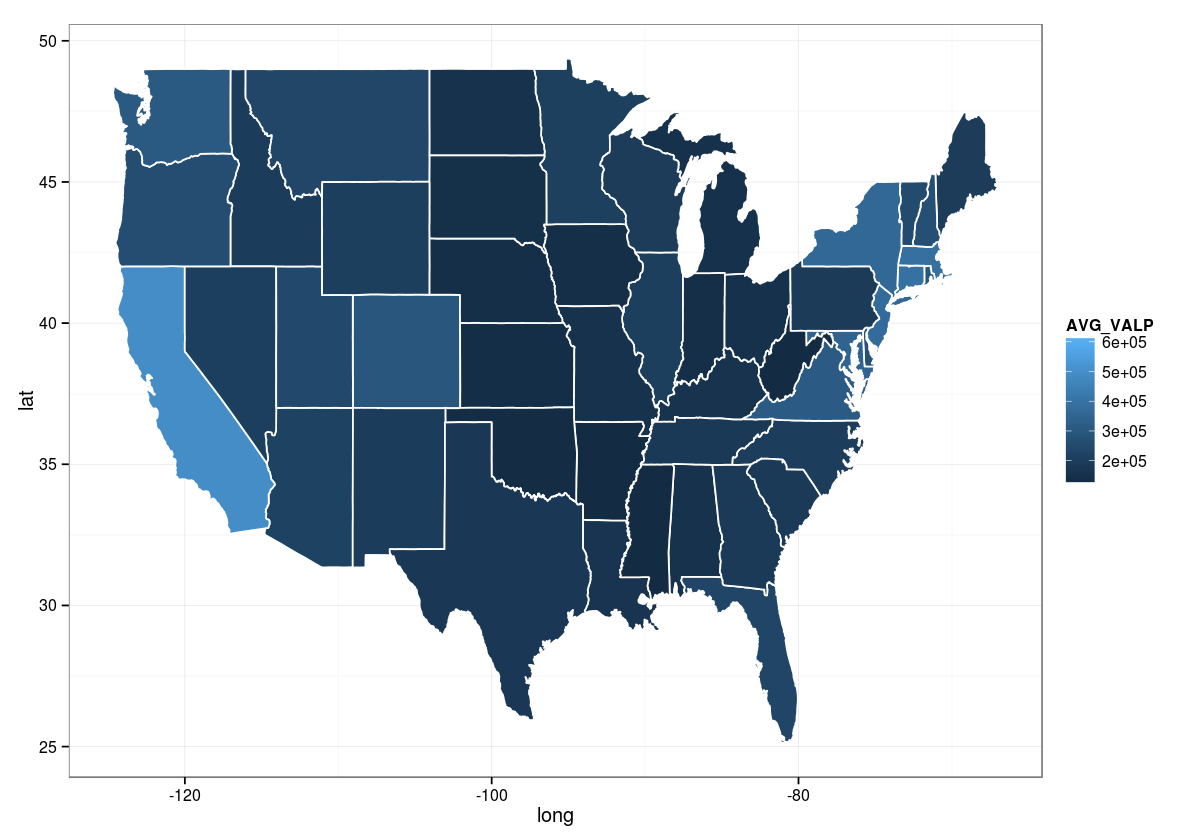

In [18]:
ggplot(merged_data, aes(x = long, y = lat, group = group, fill = AVG_VALP)) + 
    geom_polygon(color = "white") + theme_bw()

Hey, that property value map seems to make sense, right? States like California (West Coast), New York, or Washington DC (North East Coast) have the highest average property value, while interior states have the lowest.

## Exploring lot size

From now one, we will use the same code to generate a map. We will just change the variable we aggregate to get the average.

The next variable we will explore is `ACR` or lot size. It can take the following values:
- NA: not a one-family house or mobile home)
- 1: House on less than one acre
- 2: House on one to less than ten acres 
- 3: House on ten or more acres

We can consider this variable as an ordinal one where 1 represents the smaller lot and 3 the biggest. If we aggregate the average by state code, we could visualise what states tend to have larger properties on average. Let's do it as follows.

In [19]:
housing_avg <- collect(
    agg(
        groupBy(filter(housing_df, "ACR='1' OR ACR='2' OR ACR='3'"), "ST"),
        AVG=avg(housing_df$ACR)
    )
)

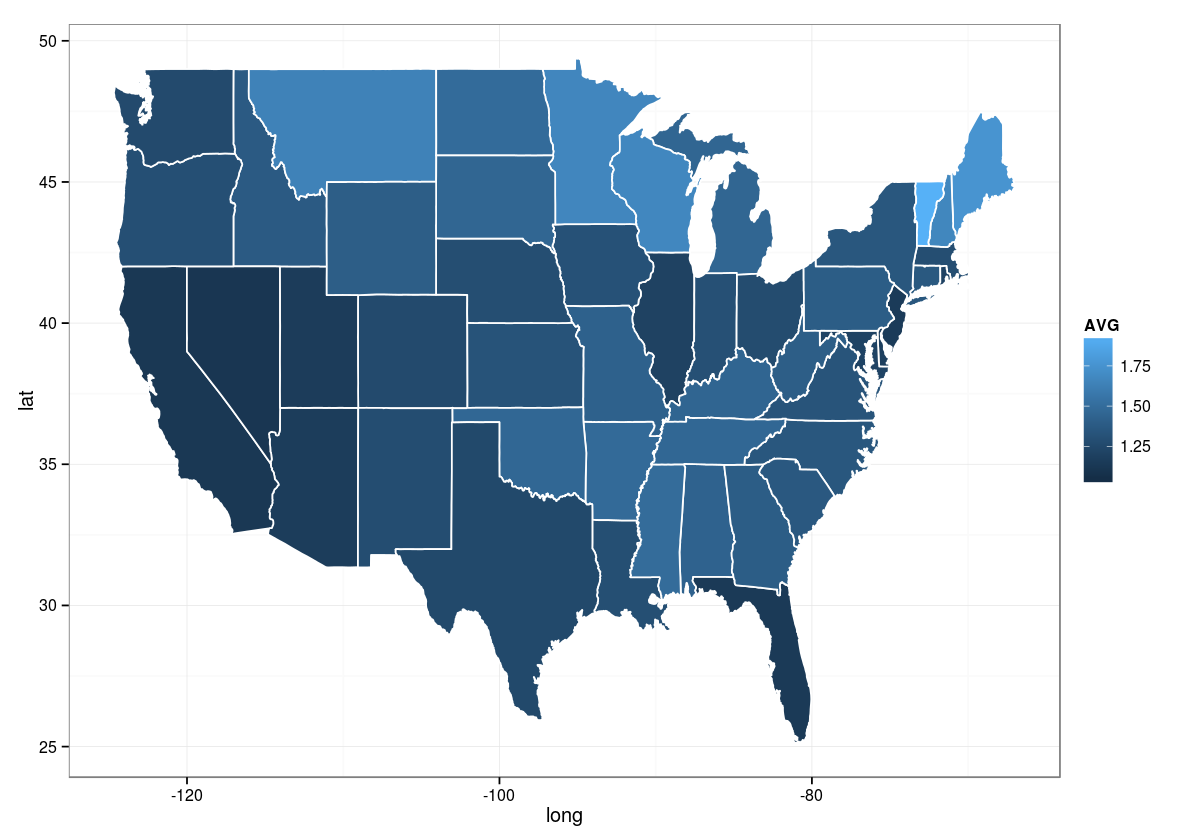

In [20]:
housing_avg$region <- factor(housing_avg$ST, levels=state_names$st, labels=tolower(state_names$name))
merged_data <- merge(states_map, housing_avg, by="region")
ggplot(merged_data, aes(x = long, y = lat, group = group, fill = AVG)) + geom_polygon(color = "white") + theme_bw()

Although there isn't an exact match, there seems to be a string relationship between lot size and [state population](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population). This relationship shows to be inverse.

## Exploring costs

There are up to four different variables refelcting the cost of a given house. In the following comparative plots, we will visualise the average values for each of them for a house grouped by state. Electricity and gas are monthly costs and fueld and water are yearly ones.

In [21]:
housing_avg <- collect(
    agg(
        groupBy(housing_df,"ST"),
        Electricity=avg(housing_df$ELEP),
        Gas=avg(housing_df$GASP),
        Fuel=avg(housing_df$FULP),
        Water=avg(housing_df$WATP)
    )
)

In [22]:
housing_avg$region <- factor(housing_avg$ST, levels=state_names$st, labels=tolower(state_names$name))
merged_data <- merge(states_map, housing_avg, by="region")

We will use the function `grid.arrage` from the package `gridExtra` (it might need installation).

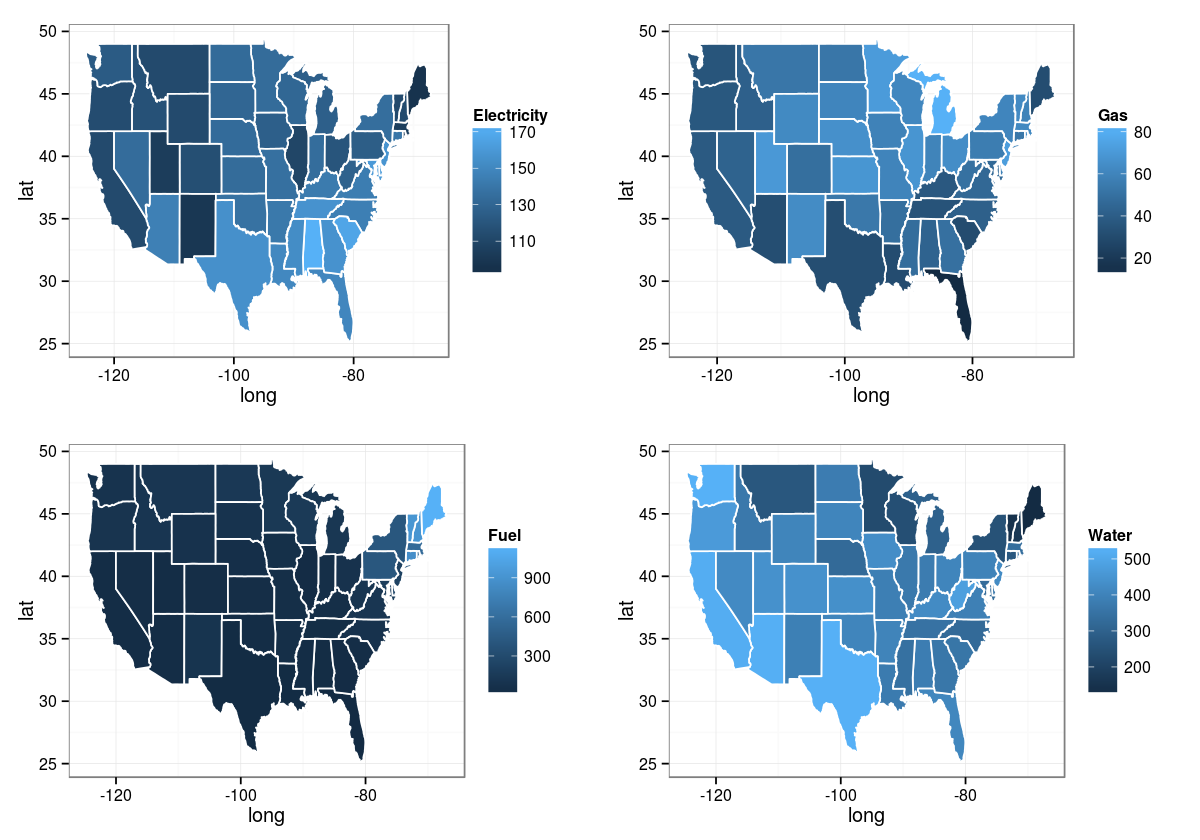

In [23]:
library(gridExtra)
p1 <- ggplot(merged_data, aes(x=long, y=lat, group=group, fill=Electricity)) + geom_polygon(color="white") + theme_bw()
p2 <- ggplot(merged_data, aes(x=long, y=lat, group=group, fill=Gas)) + geom_polygon(color="white") + theme_bw()
p3 <- ggplot(merged_data, aes(x=long, y=lat, group=group, fill=Fuel)) + geom_polygon(color="white") + theme_bw()
p4 <- ggplot(merged_data, aes(x=long, y=lat, group=group, fill=Water)) + geom_polygon(color="white") + theme_bw()

grid.arrange(p1, p2, p3, p4, ncol=2)

In the previous maps we can see how different utilities have different costs on average accross the United Stantes. For example, while the cost per month in the average house for electricity and water tends to be higher in the southern states, gas (and maybe fuel, but this is quite uniform) cost tends to be the other way around: higher cost in the average northern house. This might be related with temperature and the use of water or air conditioner versus the use of gas heatings.

## Exploring the year a property has been built

The year a propery was first built, can take the following values:

- bb: N/A (GQ)
- 01: 1939 or earlier
- 02: 1940 to 1949
- 03: 1950 to 1959
- 04: 1960 to 1969
- 05: 1970 to 1979
- 06: 1980 to 1989
- 07: 1990 to 1999
- 08: 2000 to 2004
- 09: 2005
- 10: 2006
- 11: 2007
- 12: 2008
- 13: 2009
- 14: 2010
- 15: 2011
- 16: 2012
- 17: 2013

Without really paying attention to the actual value, we will average the codes. They are order chronologically, and in the map we will be able to see states with older properties, on average, in darker colours.

In [24]:
housing_avg <- collect(
    agg(
        groupBy(housing_df, "ST"),
        AVG=avg(housing_df$YBL)
    )
)

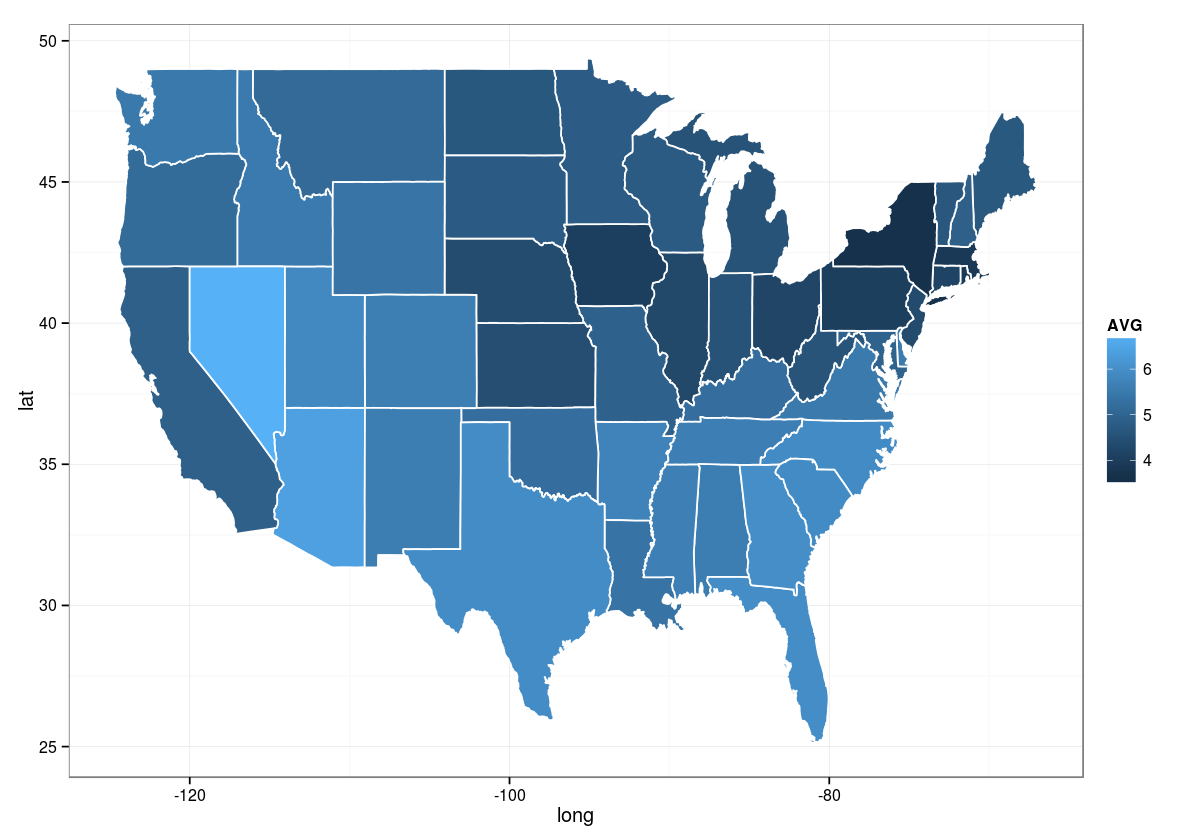

In [25]:
housing_avg$region <- factor(housing_avg$ST, levels=state_names$st, labels=tolower(state_names$name))
merged_data <- merge(states_map, housing_avg, by="region")
ggplot(merged_data, aes(x = long, y = lat, group = group, fill = AVG)) + geom_polygon(color = "white") + theme_bw()

For example, states in the north east coast, such as New York, have on average older properties. States like Nevada have the most recent ones (on average). In the west coast, California has the oldest properties. All this makes sense historically.

## Exploring rent and income

The last variable we are going to explore is `GRPIP` or the gross rent as a percentage of household income. This is a numeric varaible, not a categorical one, so the interpretation is quite straightforward. Let's map it.

In [26]:
housing_avg <- collect(
    agg(
        groupBy(housing_df, "ST"),
        AVG=avg(housing_df$GRPIP)
    )
)

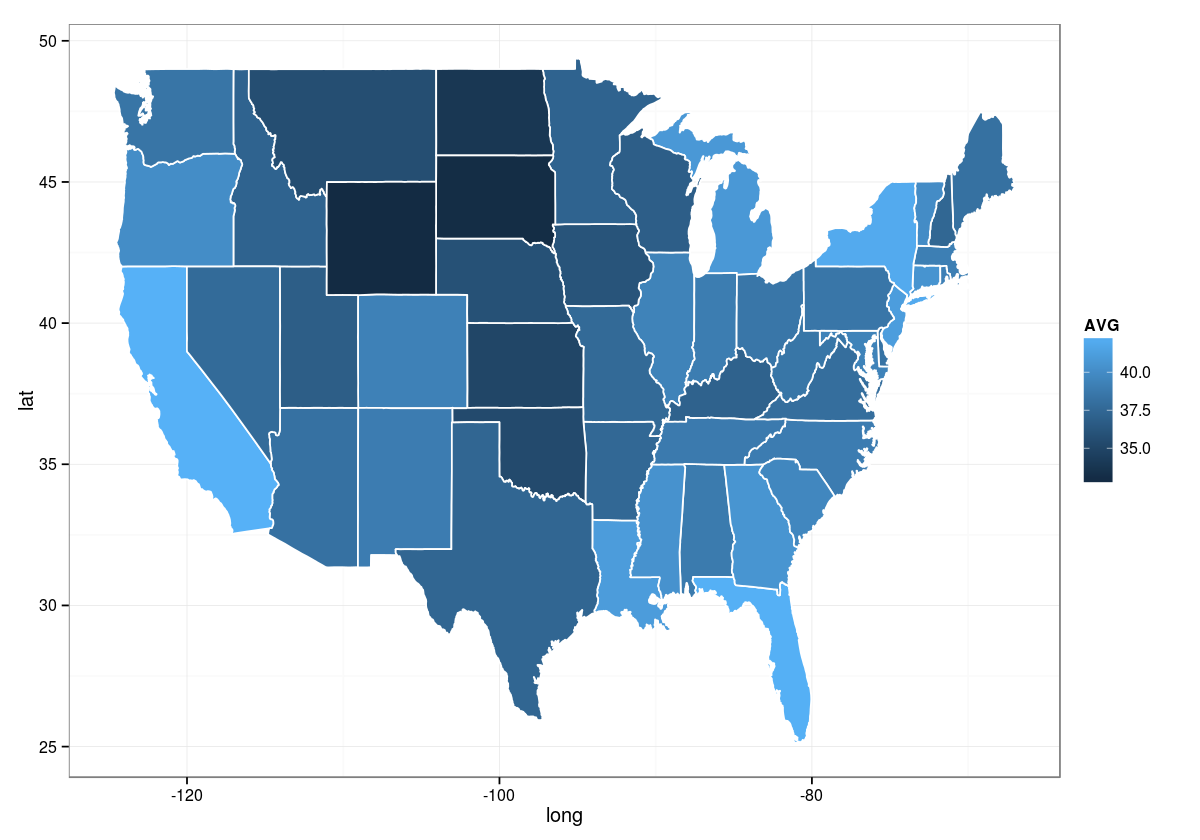

In [27]:
housing_avg$region <- factor(housing_avg$ST, levels=state_names$st, labels=tolower(state_names$name))
merged_data <- merge(states_map, housing_avg, by="region")
ggplot(merged_data, aes(x = long, y = lat, group = group, fill = AVG)) + geom_polygon(color = "white") + theme_bw()

Not surprinsingly, states such as California, New York, and Florida have the higher gross rents as a percentage of the household income (getting close to 50%), while states such as Wyoming, North Dakota, and South Dakota, have the lowest percentages. As we said, not a surprise, but it is good to have those confirmations so we know that our chart has certain accuracy. Then we can learn about other states we don't know that much about.

## Conclusions

We have shown how, by using SparkR and ggplot2 mapping capabilities we can visualise large datasets in an efficient way by solving possible scalability issues. Although the 2013 American Community Survey dataset cannot be considered dramatically large, it is big enough to be problematics for a standar R environment and traditional libraries such as *ggplot2* or *dplyr*. The guys behind SparkR have tried to replicate a good amount of the functions and abstractions we normally use in our R data processing pipelines, but using the distributed computation capabilities of Spark clusters.

Now is your turn. There are many other interesting variables to explore (e.g. taxes, number of people living in property, language spoken, etc). Go to the repo and fork the notebook so you can reproduce what we did and add your own analysis.